In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '340466',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/oqanBg2ZMXFEcZGXs5Xhjg__thumb/img/ytH65f20HAD_pWA7-adVLLKUTtM=/fit-in/200x150/filters:strip_icc()/pic6222156.png',
  'name': 'Unfathomable',
  'yearpublished': '2021'},
 {'id': '314745',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/By59lVylKiQh_ICJUgK5Tg__thumb/img/a-AYlm8qtSbpqeqydP09w1Aorfw=/fit-in/200x150/filters:strip_icc()/pic6209785.jpg',
  'name': 'Now or Never',
  'yearpublished': '2021'}]

In [6]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 30)
page number = 20 (max: 100, len: 21)
page number = 30 (max: 100, len: 16)
page number = 40 (max: 100, len: 13)
page number = 50 (max: 100, len: 7)
page number = 60 (max: 100, len: 7)
page number = 70 (max: 100, len: 5)
page number = 80 (max: 100, len: 4)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 68, len: 1)
comments_df shape: (123963, 4)


,id,username,rating,value
0,340466,Barry Kendall,N/A,Intriguing. Look forward to learning more.
1,340466,Benwax123,9,Played as play tester
2,340466,bradray,N/A,21/09
3,340466,DadouXIII,N/A,WAITING FOR PRE-ORDER
4,340466,Dark Herald,N/A,Notes: To Order
...,...,...,...,...
123958,167791,z_zadar,9,Some games are so much fun. Others can be a li...
123959,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
123960,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
123961,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [7]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [8]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 19342 for 'remove_short_comments' - min len: 25 - method: unrated


In [9]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [10]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9          19229
8          18452
10         17850
7          10185
N/A         7985
           ...  
8.95333        1
1.62           1
3.92           1
9.82           1
9.098          1
Name: rating, Length: 611, dtype: int64

In [11]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(96636, 5)

In [12]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(7985, 5)

## CREATE TRAINING AND VALIDATION DATA

In [13]:
# use rated comments (reviews) to train the model

In [14]:
rated_comments = rated_comments.sample(frac=1)

In [15]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [16]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'This is a good game, but I fail to see where the excitement comes from.  It feels like Brass, but more complicated.  Also, that board is super dark!'

In [17]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'I fail to understand the hype about this game. Game play feels very much scripted by the cards you happen to draw.'

## COMPOSE MODEL

In [20]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [21]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
48/48 - 5s - loss: 0.5510 - accuracy: 0.8040 - val_loss: 0.4717 - val_accuracy: 0.8515
Epoch 2/100
48/48 - 3s - loss: 0.4156 - accuracy: 0.8533 - val_loss: 0.3772 - val_accuracy: 0.8569
Epoch 3/100
48/48 - 3s - loss: 0.3329 - accuracy: 0.8686 - val_loss: 0.3334 - val_accuracy: 0.8708
Epoch 4/100
48/48 - 3s - loss: 0.2876 - accuracy: 0.8867 - val_loss: 0.3162 - val_accuracy: 0.8783
Epoch 5/100
48/48 - 3s - loss: 0.2561 - accuracy: 0.8986 - val_loss: 0.3106 - val_accuracy: 0.8800
Epoch 6/100
48/48 - 3s - loss: 0.2322 - accuracy: 0.9086 - val_loss: 0.3113 - val_accuracy: 0.8800
Epoch 7/100
48/48 - 3s - loss: 0.2119 - accuracy: 0.9174 - val_loss: 0.3170 - val_accuracy: 0.8773
Epoch 8/100
48/48 - 3s - loss: 0.1949 - accuracy: 0.9254 - val_loss: 0.3256 - val_accuracy: 0.8747
Epoch 9/100
48/48 - 3s - loss: 0.1805 - accuracy: 0.9325 - val_loss: 0.3376 - val_accuracy: 0.8727
Epoch 10/100
48/48 - 3s - loss: 0.1678 - accuracy: 0.9380 - val_loss: 0.3499 - val_accuracy: 0.8686
32/32 - 0

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000019D0F958F40>,
             param_grid={})

In [22]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [23]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [25]:
epochs = range(1, len(acc) + 1) 

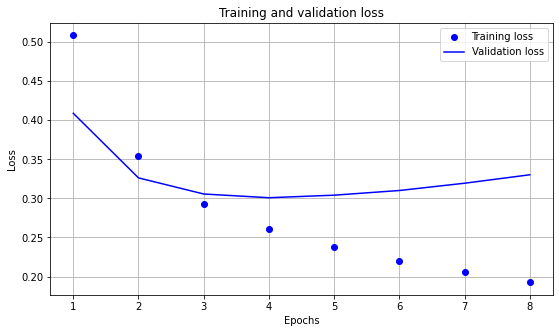

In [26]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

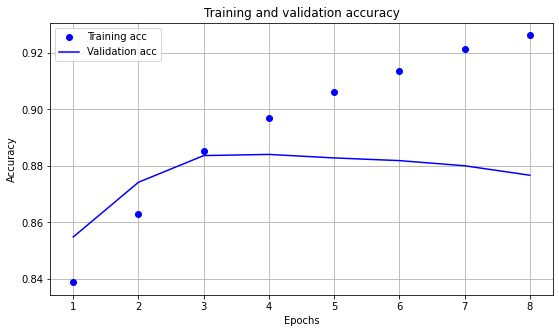

In [27]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [28]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"This is a good game, but I fail to see where the excitement comes from.  It feels like Brass, but more complicated.  Also, that board is super dark!"
score: 1.000000
actual: 1

input:
"I saw this game and thought - victory points, obscure abstract theme, tile laying... I'm just never going to play this euro.  I was wrong, I'm sorry Azul. You're pretty incredible, and filling in a nice spot on some of my favourite games. Really enjoyed this as a 2-player game. Also great with more. Always recommended, no matter the group."
score: 1.000000
actual: 1

input:
"Verliehen von SH"
score: 1.000000
actual: 1

input:
"Excellent engine building game, with a theme I enjoy.  This is a game I will bring out anytime.    Update:  With multiple plays this game has topped my list, hands down my favorite game."
score: 1.000000
actual: 1

input:
"Very nice lightweight game with enough depth to keep less casual boardgamers hooked as well. The drafting mechanism keeps it interesting. The aesthetic o

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [29]:
## APPLY MODEL ON NON-RATED COMMENTS

In [30]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

8/8 - 0s
input:
"New in shrink, I got two copies for Christmas "
score: 1.000000

input:
"Got this for Christmas. Hope to play it with Sarah and get her into the campaign."
score: 1.000000

input:
"I love this game. just wish we could have steady players."
score: 1.000000

input:
"Pre-ordered: Miniature Market US Shipment Container: mid Jan 2021 Expected mid: April 2021"
score: 1.000000

input:
"Asmodee, Frühjahr 2021 - April 2021; inkl. Captain America, Ms. Marvel & Black Widow"
score: 1.000000

input:
"Insert:  keines Sleeves: 63.5x88 ca. 53 - AT Standard"
score: 1.000000

input:
"Backed second run Kickstarter.  Preorder - Main Game - Solo Scenarios - Standees"
score: 1.000000

input:
"With Ghillie, Tink, and Nugget gearlocs. Premium health chips as well. Campaign expansions and just about everything else. Thinking about keeping just the Undertow box, character, and premium health chips and selling the rest."
score: 1.000000

input:
"Never played. Painted a couple figures."
score: 1.

## REGRESSOR

In [31]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001A04E619FD0>,
             param_grid={})

In [32]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [33]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [34]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [35]:
epochs = range(1, len(mean_squared_error) + 1) 

In [36]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.30


In [37]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 1.08


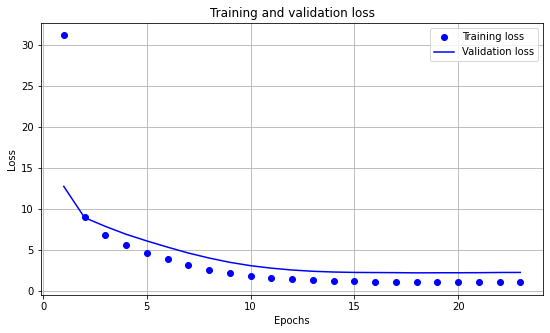

In [38]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

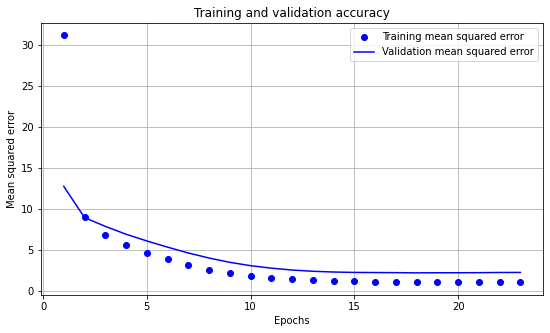

In [39]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [40]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"This is a good game, but I fail to see where the excitement comes from.  It feels like Brass, but more complicated.  Also, that board is super dark!"
score: 7.93
actual: 7.00 

input: 
"I saw this game and thought - victory points, obscure abstract theme, tile laying... I'm just never going to play this euro.  I was wrong, I'm sorry Azul. You're pretty incredible, and filling in a nice spot on some of my favourite games. Really enjoyed this as a 2-player game. Also great with more. Always recommended, no matter the group."
score: 8.72
actual: 10.00 

input: 
"Verliehen von SH"
score: 8.14
actual: 8.00 

input: 
"Excellent engine building game, with a theme I enjoy.  This is a game I will bring out anytime.    Update:  With multiple plays this game has topped my list, hands down my favorite game."
score: 9.44
actual: 9.00 

input: 
"Very nice lightweight game with enough depth to keep less casual boardgamers hooked as well. The drafting mechanism keeps it interesting. The aesth

## COMPARE CLASSIFIER VS REGRESSOR

In [41]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"Christmas gift to Bernard from Lotte and Jorgo"
    reg score: 7.46
    clf score: 1

"1-4P (best 2/3) - 30/120mn  with insert  Coop/grid movement/hand management/simultaneous action selection  EN "
    reg score: 9.07
    clf score: 1

"Birthday present for My and My husbands birthday (2021) from Matty and Kevin.  "
    reg score: 6.28
    clf score: 1

"Includes Man vs. Meeple Season 3 promo dog meeple"
    reg score: 5.56
    clf score: 1

"A fair amount of pieces.  The instructs seem well enough written.  We did get confused with rail movement, stations, and destinations, but it was late in the evening.  Overall, the game is fun and provides lots to do- even with 2 players.  Guess better not tell euro gamers that this cow trail really did exist.  Might be a historic war game if it had a giant foldout map of the central region of the USA, actual Indian tribes, and frontier settlements."
    reg score: 7.31
    clf score: 0

" I've watched all episodes of tv series.Wish to play it a

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [42]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124361 |          8.18 |           3870 |
| 162886 |          8.35 |           3562 |
| 167355 |          8.43 |           1857 |
| 167791 |          8.21 |           8327 |
| 169427 |          8.65 |            249 |


In [43]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [44]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124361 |          8.05 |            253 |
| 162886 |          8.16 |            319 |
| 167355 |          8.39 |            217 |
| 167791 |          8.22 |            443 |
| 169427 |          8.47 |             75 |


In [45]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [46]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/oqanBg2...","<a href=""https://boardgamegeek.com/boardgame/3...",9.000000,7.261799,7.510113,1,2021
1,"<img src=""https://cf.geekdo-images.com/By59lVy...","<a href=""https://boardgamegeek.com/boardgame/3...",10.000000,8.086051,8.325294,2,2021
2,"<img src=""https://cf.geekdo-images.com/MN0OvKe...","<a href=""https://boardgamegeek.com/boardgame/3...",7.519231,7.930152,7.585508,3,2021
3,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.797595,7.991433,7.813563,4,2020
4,"<img src=""https://cf.geekdo-images.com/gTxav_K...","<a href=""https://boardgamegeek.com/boardgame/2...",7.848939,8.293233,7.987353,5,2021


In [47]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [48]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Unfathomable,9.000000,7.261799,7.510113,1,2021
2,,Now or Never,10.000000,8.086051,8.325294,2,2021
3,,Imperium: Classics,7.519231,7.930152,7.585508,3,2021
4,,Lost Ruins of Arnak,7.797595,7.991433,7.813563,4,2020
5,,Oath: Chronicles of Empire and Exile,7.848939,8.293233,7.987353,5,2021


In [49]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Now or Never,10.000000,8.086051,8.325294,2,2021
2,,Deliverance,9.379167,8.591015,9.254722,8,2021
3,,Imperium: Legends,9.250000,7.814717,8.962943,30,2021
4,,Unfathomable,9.000000,7.261799,7.510113,1,2021
5,,ADELE,9.000000,8.727665,8.818443,7,2021


In [50]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Deliverance,9.379167,8.591015,9.254722,8,2021
2,,Imperium: Legends,9.250000,7.814717,8.962943,30,2021
3,,ADELE,9.000000,8.727665,8.818443,7,2021
4,,Eclipse: Second Dawn for the Galaxy,8.719187,8.243598,8.647101,38,2020
5,,Brass: Birmingham,8.677645,8.184952,8.634223,27,2018


In [51]:
# model.save('saved_model\my_model')

In [52]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [53]:
# some examples on "long" comments vs short comments

In [54]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [55]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"I picked up this game after hearing how great it was and was sure it would go well with my group, but wow did it fall flat. I think it took too long for what it was, and while I enjoyed it, it seemed others were ready for it to be over halfway through. "
score: 5.89

"Played it only once and we had to rush the end to finish it. Sour taste as there was little interaction between played because we were too focused on our own game and strategy to look at what the others were doing.  Willing to try more as I feel there is a steep learning curve."
score: 5.92

"Watched Tom Vasel's review (partially). Why is this a board game? App-driven but beyond reason, seems like it should be a videogame instead."
score: 6.30

"Lots of fun, interesting dynamics and teaches you not to trust anyone! Feels a lot like the TV show in that respect."
score: 6.30

"wishlist - people seem to like the traitor aspect of this game.  Now I'm thinking Dead of Winter is a better traitor game."
score: 6.36

"Play the o

## RANDOM FOREST - TEST

In [56]:
# no support for Windows at the moment - waiting for it to test